In [183]:
'''
Important imports for the Project
Includes imports for imaging, array creation and animation
'''
import random 
import numpy as np
import math
import matplotlib.pyplot as plt
import time  
from IPython.display import display, clear_output
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data

In [184]:
class bacteria():
    
    __slots__ = ['x', 'y', 'antibiotic_resistance_gene', 'nutrient_gene', 'temperature_gene', 'toxin_gene', 'mutation_rate', 'reproduction_rate', 'visited', 'age']
    
    def __init__(self, x = random.randint(0,215),y = random.randint(0,215), anti = 0, nutri = 0, temp = 0, toxin = 0, mutation_rate=0.5, reproduction_rate=0.5):
        """
        Creates new bacteria object with random position and genes
        :x: x position of bacteria
        :y: y position of bacteria
        :mutation_rate: the mutation rate for bacteria
        :reproduction_rate: the rate of reproduction for bacteria
        :nutrient_gene: gene corresponding to how high nutrients is needed for faster movement
        :antibiotic_resistance_gene: gene corresponding to antibiotic resistance for bacteria
        :temperature_gene: gene corresponding to temperature resistance for bacteria
        :toxin_gene: gene corresponding to toxin output for bacteria
        """
        self.x = x
        self.y = y
        self.age = 0
        
        #visited flag for
        self.visited = False
        
        #initialize all genes to random values between [0, 0.2] + gene_seed
        self.antibiotic_resistance_gene = np.random.rand()/5 + anti
        self.nutrient_gene = np.random.rand()/5 + nutri
        self.temperature_gene = np.random.rand()/5 + temp
        self.toxin_gene = np.random.rand()/5 + toxin
        self.mutation_rate = mutation_rate
        self.reproduction_rate = reproduction_rate
        
    
    def set_position(self, x, y):
        """
        Sets the position of self(bacterial position) using passed arguments
        """
        self.x = x
        self.y = y
        return
    
    def get_pos(self):
        '''
        Used to return the bacterial position at that point in time
        '''
        return self.x, self.y
    
    def movement(self, board):
        """
        Randomly move bacteria in the x and y directions based on position in high nutrients nutrients.
        Otherwise, the bacteria moves less quickly. Make sure bacteria stay within the limits of the board
        Bacteria moves more quickly when in high nutrient regions than when in low nutrient regions
        """
        if board.get_nutrients(self.x, self.y) > 1-self.nutrient_gene/2: #bacteria will move more if in high level of nutrients
            new_x = self.x + np.random.randint(-2, 3)
            new_y = self.y + np.random.randint(-2, 3)
        else:
            new_x = self.x + np.random.randint(-1, 2)
            new_y = self.y + np.random.randint(-1, 2)
            
        if new_x < 0:
            new_x = 0
        if new_x >= board.ncols:
            new_x = board.ncols - 1

        if new_y < 0:
            new_y = 0
        if new_y >= board.nrows:
            new_y = board.nrows - 1
            
        if not board.get_bacteria(new_x, new_y):
            board.remove_bacteria(self.x,self.y)
            self.x = new_x
            self.y = new_y
            board.add_bacteria(self.x, self.y, self)
            
        return

    
    def reproduce(self, board):
        """
        Returns a new bacteria with genes based off of parent (self)
        Reproduction rate boosted if in nutrient dense area
        Reproduction rate decreased if in high antibiotics
        """
        if np.random.rand() < (self.reproduction_rate * (1+board.get_nutrients(self.x, self.y))/(1+board.get_antibiotics(self.x, self.y))):  # randomly chooses value from [0,1], if value is less than reproduction rate * (nutrient level/antibiotic level) it reproduces
            openings = board.get_openings(self.y, self.x)
            if openings is not None:
                loc = random.randint(0,len(openings)-1)
                newbac = bacteria(openings[loc][1], openings[loc][0], self.antibiotic_resistance_gene, self.nutrient_gene, self.temperature_gene, self.toxin_gene, self.mutation_rate, self.reproduction_rate)
                board.add_bacteria(openings[loc][1], openings[loc][0], newbac)
                if newbac.death(board):
                    board.remove_bacteria(openings[loc][1], openings[loc][0])
        return
    
    
    def mutate(self, negative=False):
        """
        Randomly calculate if bacteria will mutate
        If true, randomly add from a N(0, 0.1) distribution
        Genes mutate independently
        :negative: If true, the genes will have a bias to decrease
        """
        weight = 0
        if negative:
            weight = -0.05
        
        if np.random.rand() < self.mutation_rate:
            self.antibiotic_resistance_gene += (0.1 * np.random.rand() + weight)
        if np.random.rand() < self.mutation_rate:
            self.nutrient_gene += (0.1 * np.random.rand() + weight)
        if np.random.rand() < self.mutation_rate:
            self.temperature_gene += (0.1 * np.random.rand() + weight)
        if np.random.rand() < self.mutation_rate:
            self.toxin_gene += (0.1 * np.random.rand() + weight)
        return
    
    def death(self, the_board):
        """
        Decide whether the gene can overcome the conditions on the board, if not the bacteria dies
        :external_condition_value: antibiotics level, toxin level, temperature
        """
        if self.antibiotic_resistance_gene < the_board.get_antibiotics(self.x,self.y):
            return True
        if self.toxin_gene < the_board.get_toxin(self.x,self.y):
            return True
        if self.temperature_gene < the_board.get_temperature():
            return True
        if self.age >= 10:
            return True
        return False
    
    def update(self, board, negative=False):
        '''
        updates a bacteria
        calls all other methods (movement, reproduce, mutate, death, toxins)
        returns new x and y coordinates of bacteria
        '''
        self.age += 1
        if self.death(board):
            board.remove_bacteria(self.x, self.y)
            return None
        board.toxins(self)
        self.mutate(negative)
        self.reproduce(board)
        self.movement(board)
        return (self.x, self.y)
    


In [188]:
class board():
    
    __slots__ = ['nrows', 'ncols', '_nutrients', '_antibiotics', '_temperature','_toxins', '_bacteria']
    
    def __init__(self, nrows = 9, ncols = 9):
        '''
        Initializes board with given rows and columns
        creates nutrients, anti, toxins, and bacteria private attributes
        initializes bacteria in column 0
        '''
        self.nrows = nrows
        self.ncols = ncols
        self._nutrients = np.zeros((self.nrows,self.ncols))
        self._antibiotics = np.zeros((self.nrows,self.ncols))
        self._toxins = np.zeros((self.nrows,self.ncols))
        self._temperature = 0
        
        self._bacteria = np.full([self.nrows,self.ncols], None)
        
        #initializes bacteria in column 0, bacteria have alternating .5 and .2 mutation rate
        for y_val in range(nrows):
            if y_val%2 == 0:
                self._bacteria[y_val,0] = bacteria(0,y_val,mutation_rate = 0.1)
            else:
                self._bacteria[y_val,0] = bacteria(0,y_val,mutation_rate = 0.5)
        self.nutrients()
        self.antibiotics()
    
    def nutrients(self):
        '''
        adds values to nutrients board, in the form of 6 columns
        displays nutrients attribute
        '''
        for col in range(self.ncols):
            if col < self.ncols/6:
                self._nutrients[:,col] = 0
            elif col < 2*self.ncols/6:
                self._nutrients[:,col] = .2
            elif col < 3*self.ncols/6:
                self._nutrients[:,col] = .4
            elif col < 4*self.ncols/6:
                self._nutrients[:,col] = .6
            elif col < 5*self.ncols/6:
                self._nutrients[:,col] = .8
            else:
                self._nutrients[:,col] = 1
        
        plt.matshow(self._nutrients)
        
        x_temp = self.ncols//6
        y_temp = self.nrows//6
        x_ticks = [x_temp,2*x_temp,3*x_temp,4*x_temp,5*x_temp]
        y_ticks = [y_temp,2*y_temp,3*y_temp,4*y_temp,5*y_temp]
        plt.xticks(x_ticks,x_ticks)
        plt.yticks(y_ticks,y_ticks)
        plt.show()
        return

    def antibiotics(self):
        '''
        adds values to antibiotics board, in the form of 6 rows
        displays antibiotics attribute
        '''
        for row in range(self.nrows):
            if row < self.nrows/6:
                self._antibiotics[row,:] = 0
            elif row < 2*self.nrows/6:
                self._antibiotics[row,:] = .2
            elif row < 3*self.nrows/6:
                self._antibiotics[row,:] = .4
            elif row < 4*self.nrows/6:
                self._antibiotics[row,:] = .6
            elif row < 5*self.nrows/6:
                self._antibiotics[row,:] = .8
            else:
                self._antibiotics[row,:] = 1
        
        plt.matshow(self._antibiotics)
     
        x_temp = self.ncols//6
        y_temp = self.nrows//6
        x_ticks = [x_temp,2*x_temp,3*x_temp,4*x_temp,5*x_temp]
        y_ticks = [y_temp,2*y_temp,3*y_temp,4*y_temp,5*y_temp]
        plt.xticks(x_ticks,x_ticks)
        plt.yticks(y_ticks,y_ticks)
        plt.show()
        return
    
    def toxins(self,bacteria, weight=2):
        '''
        Bacteria releases toxin based on its genes, increases toxin at its board location
        '''
        pos = bacteria.get_pos()
        xpos = pos[0]
        ypos = pos[1]
        if bacteria.toxin_gene > 1: # or bacteria.toxin_gene < 1:
            self._toxins[ypos,xpos] += bacteria.toxin_gene/weight
        return 
    
    def temperature(self, weight = 0.01):
        '''
        Updates the temperature on the board, slowly heats board up
        '''
        self._temperature += weight #board slowly heating up, weight switches how fast it heats
        return
    
    def get_nutrients(self, x, y):
        '''
        returns nutrient value at point
        '''
        return self._nutrients[y,x]
    
    def get_antibiotics(self, x, y):
        '''
        returns antibiotic value at point
        '''
        return self._antibiotics[y,x]
    
    def get_toxin(self, x, y):
        '''
        returns toxin value at point
        '''
        return self._toxins[y,x]
    
    def get_temperature(self):
        '''
        returns temperature value of board
        '''
        return self._temperature
    
    def add_bacteria(self, x, y, to_add):
        '''
        adds a bacteria at point
        '''
        self._bacteria[y,x] = to_add
        return
    
    def remove_bacteria(self, x, y):
        '''
        empties location at point
        '''
        self._bacteria[y,x] = None
        
    def set_visited(self, x, y, flag):
        """
        Sets the bacteria at [x,y] to visited so it is not updated twice in the update function
        """
        self._bacteria[y,x].visited = flag
    
    def reset_all_bac(self):
        """
        Resets the visited flag on all bacteria once the update iteration is over
        """
        for row in range(self.nrows):
            for col in range(self.ncols):
                if self._bacteria[row,col]:
                    self.set_visited(col, row, False)
    
    def update(self, negative=False):
        '''
        updates the board
        :negative: Parameter for whether bacteria will on average mutate with lower genes
        '''
        board.temperature(self) #updates temperature
        for row in range(self.nrows):
            for col in range(self.ncols):
                if self._bacteria[row,col] is not None and not self._bacteria[row, col].visited:
                    new_coords = self._bacteria[row,col].update(self, negative)
                    if new_coords:
                        self.set_visited(new_coords[0], new_coords[1], True)
                self._toxins[row,col] = max(0, self._toxins[row,col] - 0.2)
        self.reset_all_bac()
                         
    def in_region(self,row,col):
        '''
        returns boolean representing if a location is within the depicted region's boundaries
        '''
        if row < self.nrows and row >= 0 and col < self.ncols and col >= 0:
            return True
        else:
            return False
    def get_bacteria(self, x, y):
        '''
        Return True if a bacteria currently populates the current x, y position
        '''
        if self._bacteria[y, x] is not None:
            return True
        return False
        
    def get_openings(self,row,col):
        '''
        Von Neumann neighborhood, meaning all spaces next to it, including diagonals
        Returns empty neighbors on bacteria board
        '''
        surroundings = [(row-1, col), (row, col-1), (row+1, col), (row, col+1), (row-1,col-1), (row-1,col+1), (row+1,col-1), (row+1,col+1)]

        open_locations = []
        for neighbor in surroundings:
            if self.in_region(neighbor[0], neighbor[1]) and self._bacteria[neighbor[0], neighbor[1]] is None:
                open_locations.append(neighbor)
        if (len(open_locations) > 0):
            return open_locations
        return None
                
    def display(self):
        '''
        displays the board
        will display all bacteria on the board, and axes will show antibiotic and nutrient levels
        '''
        x = np.arange(0, self.ncols, 1)
        y = np.arange(0, self.nrows, 1)
        X, Y = np.meshgrid(x, y)
        extent = np.min(x), np.max(x), np.min(y), np.max(y)
        fig = plt.figure(frameon=False)
        Z1 = np.add.outer(range(6), range(6)) % 2  # chessboard
        im1 = plt.imshow(Z1, cmap=plt.cm.gray, interpolation='nearest',
                 extent=extent)
        

        cmap = plt.cm.get_cmap('RdPu')
        cmap2 = plt.cm.get_cmap('GnBu')
        weight = self.get_max_gene_val('toxin')
        for x_val in range(self.ncols):
            for y_val in range(self.nrows):
                if self._bacteria[y_val,x_val] is not None:
                    if self._bacteria[y_val,x_val].mutation_rate == 0.1:
                        plt.scatter(x_val,y_val, color=cmap(self._bacteria[y_val,x_val].toxin_gene/weight))
                    else:
                        plt.scatter(x_val,y_val, color=cmap2(self._bacteria[y_val,x_val].toxin_gene/weight))
        
        x_temp = self.ncols//6
        y_temp = self.nrows//6
        x_ticks = [x_temp,2*x_temp,3*x_temp,4*x_temp,5*x_temp]
        y_ticks = [y_temp,2*y_temp,3*y_temp,4*y_temp,5*y_temp]
        plt.xticks(x_ticks,[.2,.4,.6,.8,1])
        plt.yticks(y_ticks,[.2,.4,.6,.8,1])
        plt.ylabel("antibiotics level")
        plt.xlabel("nutrients level")
        plt.show()
        print('Bacteria Count: ', self.get_num_bac())

        
        
    def get_num_bac(self):
        '''
        counts the number of bacteria
        '''
        count = 0
        for x_val in range(self.ncols):
            for y_val in range(self.nrows):
                if self._bacteria[y_val,x_val] is not None:
                    count += 1
        return count
    
    
    def get_num_type_bac(self, mut_rate):
        '''
        counts the number of bacteria with a specific mutation rate
        '''
        count = 0
        for x_val in range(self.ncols):
            for y_val in range(self.nrows):
                if self._bacteria[y_val,x_val] is not None and self._bacteria[y_val,x_val].mutation_rate == mut_rate:
                    count += 1
        return count
    
    
    def get_max_gene_val(self, gene):
        """
        Returns the max gene value of all bacteria on the board
        :gene: the gene to get the max value of
        """
        max_val = -np.inf
        if gene == 'antibodies':
            for row in range(self.nrows):
                for col in range(self.ncols):
                    if self.get_bacteria(col, row) and self._bacteria[row, col].antibiotic_resistance_gene > max_val:
                        max_val = self._bacteria[row, col].antibiotic_resistance_gene
        elif gene == 'toxin':
            for row in range(self.nrows):
                for col in range(self.ncols):
                    if self.get_bacteria(col, row) and self._bacteria[row, col].toxin_gene > max_val:
                        max_val = self._bacteria[row, col].toxin_gene
        return max_val
    
    def get_average_vals(self):
        """
        Returns a tuple containing average gene values for all bacteria and average toxin levels on board
        :return: (avg_antibiotic_gene_val, avg_toxin_gene_val, avg_board_toxicity)
        """
        avg_anti = avg_toxin = avg_toxicity = count = 0
        for row in range(self.nrows):
            for col in range(self.ncols):
                avg_toxicity += self.get_toxin(col, row)
                if self.get_bacteria(col, row):
                    count += 1
                    avg_anti += self._bacteria[row, col].antibiotic_resistance_gene
                    avg_toxin += self._bacteria[row, col].toxin_gene
        return (avg_anti/count, avg_toxin/count, avg_toxicity/(self.ncols*self.nrows))
    
    
    def get_average_vals_onetype(self, mut_rate):
        """
        Returns a tuple containing average gene values for bacteria of one type
        :return: (avg_antibiotic_gene_val, avg_toxin_gene_val)
        """
        avg_anti = avg_toxin = count = 0
        for row in range(self.nrows):
            for col in range(self.ncols):
                if self.get_bacteria(col, row) and self._bacteria[row, col].mutation_rate == mut_rate:
                    count += 1
                    avg_anti += self._bacteria[row, col].antibiotic_resistance_gene
                    avg_toxin += self._bacteria[row, col].toxin_gene
        if count == 0:
            return 0, 0
        return (avg_anti/count, avg_toxin/count)
        

iteration number 100


<Figure size 432x288 with 0 Axes>

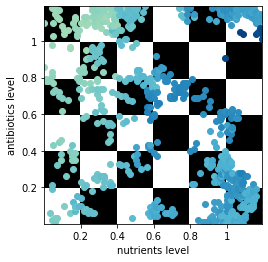

Bacteria Count:  694


In [248]:
height = 120
width = 120
iterations = 100
show_every = 100

bac_count = [None] * iterations
bac_count_type1 = [None] * iterations
bac_count_type2 = [None] * iterations

bac_avg_anti_gene = [None] * iterations
bac_avg_anti_gene_type1 = [None] * iterations
bac_avg_anti_gene_type2 = [None] * iterations

bac_avg_toxin_gene = [None] * iterations
bac_avg_toxin_gene_type1 = [None] * iterations
bac_avg_toxin_gene_type2 = [None] * iterations

board_avg_toxicity = [None] * iterations

print("beginning")
table = board(height, width)
print("bacteria locations:")
table.display()
mylist = []
for i in range(iterations):
    plt.clf()
    clear_output(wait = True)  
    print("iteration number",i+1)
    table.update()
    if i%show_every == 0:
        table.display()
        time.sleep(2)
    bac_count[i] = table.get_num_bac()
    bac_count_type1[i] = table.get_num_type_bac(.1)
    bac_count_type2[i] = table.get_num_type_bac(.5)
    if bac_count[i] == 0:
        break
    mylist.append(table.get_temperature()) #tracks temperature since it is consistent throughout the board
    bac_avg_anti_gene[i], bac_avg_toxin_gene[i], board_avg_toxicity[i] = table.get_average_vals()
    bac_avg_anti_gene_type1[i], bac_avg_toxin_gene_type1[i] = table.get_average_vals_onetype(.1)
    bac_avg_anti_gene_type2[i], bac_avg_toxin_gene_type2[i] = table.get_average_vals_onetype(.5)
table.display()

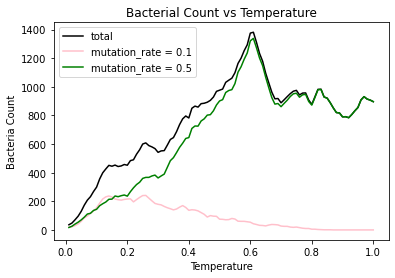

In [240]:
plt.plot(mylist, bac_count, color = "black", label = 'total')
plt.plot(mylist, bac_count_type1, color = "pink", label = 'mutation_rate = 0.1')
plt.plot(mylist, bac_count_type2, color = 'green', label = 'mutation_rate = 0.5')
plt.title('Bacterial Count vs Temperature')
plt.xlabel('Temperature')
plt.ylabel('Bacteria Count')
plt.legend()

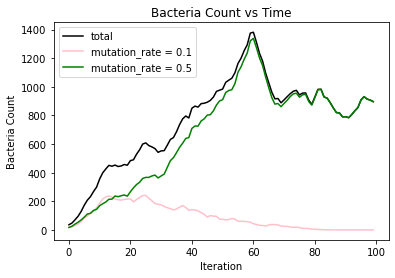

In [241]:
plt.plot(bac_count, color = 'black', label = 'total')
plt.plot(bac_count_type1, color = "pink", label = 'mutation_rate = 0.1')
plt.plot(bac_count_type2, color = 'green', label = 'mutation_rate = 0.5')
plt.title('Bacteria Count vs Time')
plt.xlabel('Iteration')
plt.ylabel('Bacteria Count')
plt.legend()

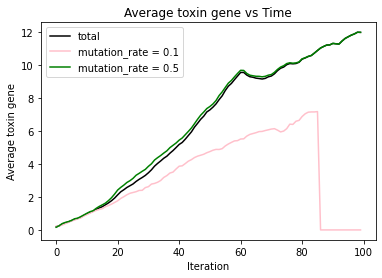

In [242]:
plt.plot(bac_avg_toxin_gene, color = 'black', label = 'total')
plt.plot(bac_avg_toxin_gene_type1, color = "pink", label = 'mutation_rate = 0.1')
plt.plot(bac_avg_toxin_gene_type2, color = 'green', label = 'mutation_rate = 0.5')
plt.title('Average toxin gene vs Time')
plt.xlabel('Iteration')
plt.ylabel('Average toxin gene')
plt.legend()

Text(0, 0.5, 'Average toxicity')

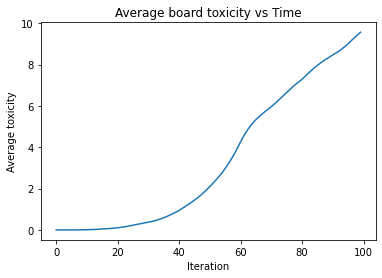

In [243]:
plt.plot(board_avg_toxicity)
plt.title('Average board toxicity vs Time')
plt.xlabel('Iteration')
plt.ylabel('Average toxicity')

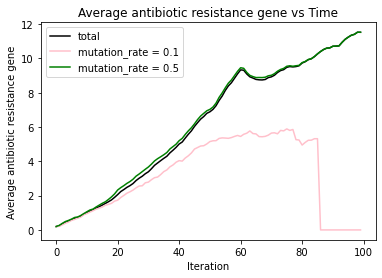

In [244]:
plt.plot(bac_avg_anti_gene, color = 'black', label = 'total')
plt.plot(bac_avg_anti_gene_type1, color = "pink", label = 'mutation_rate = 0.1')
plt.plot(bac_avg_anti_gene_type2, color = 'green', label = 'mutation_rate = 0.5')
plt.title('Average antibiotic resistance gene vs Time')
plt.xlabel('Iteration')
plt.ylabel('Average antibiotic resistance gene')
plt.legend()

## Simulation where mutation rate has negative bias

iteration number 100


<Figure size 432x288 with 0 Axes>

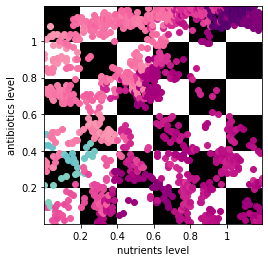

Bacteria Count:  1167


In [230]:
height = 120
width = 120
iterations = 100
show_every = 100

bac_count = [None] * iterations
bac_count_type1 = [None] * iterations
bac_count_type2 = [None] * iterations

bac_avg_anti_gene = [None] * iterations
bac_avg_anti_gene_type1 = [None] * iterations
bac_avg_anti_gene_type2 = [None] * iterations

bac_avg_toxin_gene = [None] * iterations
bac_avg_toxin_gene_type1 = [None] * iterations
bac_avg_toxin_gene_type2 = [None] * iterations

board_avg_toxicity = [None] * iterations

print("beginning")
table = board(height, width)
print("bacteria locations:")
table.display()
mylist = []
for i in range(iterations):
    plt.clf()
    clear_output(wait = True)  
    print("iteration number",i+1)
    table.update(negative = True)
    if i%show_every == 0:
        table.display()
        time.sleep(2)
    bac_count[i] = table.get_num_bac()
    bac_count_type1[i] = table.get_num_type_bac(.1)
    bac_count_type2[i] = table.get_num_type_bac(.5)
    if bac_count[i] == 0:
        break
    mylist.append(table.get_temperature()) #tracks temperature since it is consistent throughout the board
    bac_avg_anti_gene[i], bac_avg_toxin_gene[i], board_avg_toxicity[i] = table.get_average_vals()
    bac_avg_anti_gene_type1[i], bac_avg_toxin_gene_type1[i] = table.get_average_vals_onetype(.1)
    bac_avg_anti_gene_type2[i], bac_avg_toxin_gene_type2[i] = table.get_average_vals_onetype(.5)
table.display()

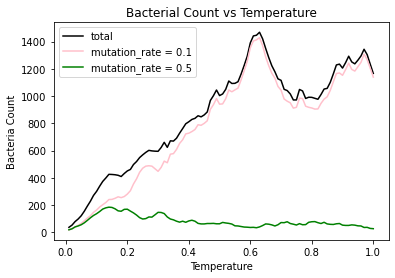

In [231]:
plt.plot(mylist, bac_count, color = "black", label = 'total')
plt.plot(mylist, bac_count_type1, color = "pink", label = 'mutation_rate = 0.1')
plt.plot(mylist, bac_count_type2, color = 'green', label = 'mutation_rate = 0.5')
plt.title('Bacterial Count vs Temperature')
plt.xlabel('Temperature')
plt.ylabel('Bacteria Count')
plt.legend()

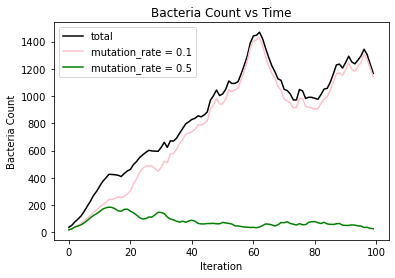

In [232]:
plt.plot(bac_count, color = 'black', label = 'total')
plt.plot(bac_count_type1, color = "pink", label = 'mutation_rate = 0.1')
plt.plot(bac_count_type2, color = 'green', label = 'mutation_rate = 0.5')
plt.title('Bacteria Count vs Time')
plt.xlabel('Iteration')
plt.ylabel('Bacteria Count')
plt.legend()

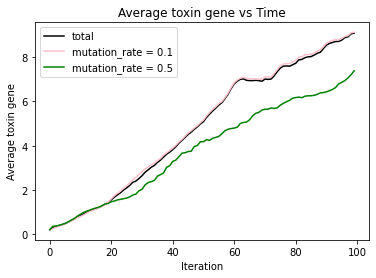

In [233]:
plt.plot(bac_avg_toxin_gene, color = 'black', label = 'total')
plt.plot(bac_avg_toxin_gene_type1, color = "pink", label = 'mutation_rate = 0.1')
plt.plot(bac_avg_toxin_gene_type2, color = 'green', label = 'mutation_rate = 0.5')
plt.title('Average toxin gene vs Time')
plt.xlabel('Iteration')
plt.ylabel('Average toxin gene')
plt.legend()

Text(0, 0.5, 'Average toxicity')

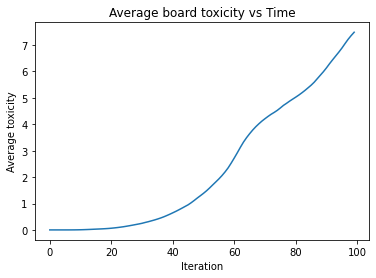

In [234]:
plt.plot(board_avg_toxicity)
plt.title('Average board toxicity vs Time')
plt.xlabel('Iteration')
plt.ylabel('Average toxicity')

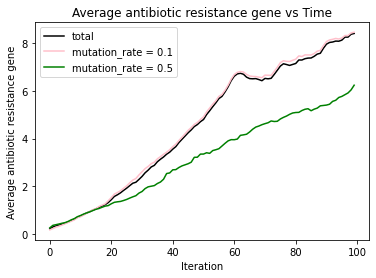

In [235]:
plt.plot(bac_avg_anti_gene, color = 'black', label = 'total')
plt.plot(bac_avg_anti_gene_type1, color = "pink", label = 'mutation_rate = 0.1')
plt.plot(bac_avg_anti_gene_type2, color = 'green', label = 'mutation_rate = 0.5')
plt.title('Average antibiotic resistance gene vs Time')
plt.xlabel('Iteration')
plt.ylabel('Average antibiotic resistance gene')
plt.legend()